# Introduction

This research notebook is trying to following the outline from our gitter room at [Pyanp Lobby](https://gitter.im/pythonanp/Lobby).  The steps, copied from that room are:

1. Define ratio distance between 2 matrices
2. Define ratio distance between a matrix and its pairwise comparison vector, call this function $r(M)$
3. Define a method of creating a universe of pairwise comparisons $U_n$ for the universe of nxn matrices to normalize wrt
4. Calculate the ratio distance for each $M \in U_n$, create that list of values, call it $r(U_n)$. This gives a list of values.
5. Calculate the percentile scores of each element of $r(U_n)$, call the percentile score of the matrix $M$ call it $p(M)$, and we then have a list of pairs $(r(M),p(M))$ for each $M\in U_n$. Call this list of pairs $N(U_n)$ for "normalization data of $U_n$"
6. Use $N(U_n)$ as our normalizer function, you could for instance just do piecewise linear on that data to convert any raw ratio distance to the percentile score.
7. Ideally look at plots of this data, to see if there is a function that would approximate....my guess is logistic
8. Hopefully find a pattern for the function approximation for large n's so we can have a general formula
9. Use $N(U_n)$ combined with Saaty inconsistency to compare the two measures
10. Discuss why this new measure is easier for users to understand the values of it

## Import needed libraries

In [1]:
from pyanp.priority import *
from IPython.display import display, HTML, Markdown, Math
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (12,7)

In [3]:
def ratio_dist(a, b, zero_uncmp=False):
    if (a == 0) or (b == 0):
        if zero_uncmp:
            return 0
        else:
            return 1
    else:
        return max(np.abs(a/b), np.abs(b/a))

def ratio_dist_mat(m1, m2, cmp_utm=True):
    rval = 1
    count = 0
    size = len(m1)
    for row in range(size):
        for col in range(row+1, size):
            val=ratio_dist(m1[row,col], m2[row,col], zero_uncmp=True)
            if val != 0:
                rval *= val
                count += 1
    if count > 0:
        return rval ** (1.0/count)
    else:
        return 1

def ar_consistency(mat, pcalc=pri_eigen):
    pri = pcalc(mat)
    con_mat = ratio_mat(pri)
    return ratio_dist_mat(mat, con_mat)

def rnd_cmp_mat_exp(size, max_vote=9):
    rval = np.identity(size)
    max_exponent = np.log(max_vote)
    for row in range(size):
        for col in range(row+1, size):
            rval[row, col]=np.exp(rnd.random()*max_exponent)
            #Should we invert
            if rnd.random() > 0.5:
                rval[row,col] = 1/rval[row, col]
            rval[col, row] = 1/rval[row, col]
    return rval

def rnd_cmp_mat(size, max_vote=9):
    rval = np.identity(size)
    for row in range(size):
        for col in range(row+1, size):
            rval[row, col]=rnd.random()*(max_vote-1)+1
            #Should we invert
            if rnd.random() > 0.5:
                rval[row,col] = 1/rval[row, col]
            rval[col, row] = 1/rval[row, col]
    return rval

def percentile_sorted(sorted_list):
    size =len(sorted_list)
    rval = np.zeros([size])
    i=0
    while i < size:
        val = sorted_list[i]
        did_break = False
        for j in range(i+1, size):
            if sorted_list[j] != val:
                did_break=True
                #print("We broke, good at j="+str(j))
                break
        #From i to j are the values that equal val
        #so from 0 to i-1 are the values less, i.e. there are i of them
        #and j-i+1 values equal to val (those count 1/2)
        #print("Found range i="+str(i)+" to j="+str(j))
        #Also if we never broke, that means all rest were same, so
        if not did_break:
            j=size
        per_val = (i + (j-i+1)*1/2)/size
        for k in range(i, j):
            rval[k] = per_val
        if j==(size-1):
            if i==j:
                rval[j]=(size-0.5)/size
            else:
                rval[j]=per_val
            break
        i=j
    return rval

# Some initial calculations

## Let's calculate for a simple matrix

In [4]:
m1 = np.array([
    [1, 2, 5],
    [1/2, 1, 3],
    [1/6, 1/3, 1]
])
ar_consistency(m1)

1.0626585691826111

This result makes sense, the minimal value would be 1, and this is just a smidgen higher

## Let's calculate it for some random matrices

### Random 4x4 entries with values 1-9 including decimals and inverses

In [5]:
rnd_matrices = [rnd_cmp_mat(4) for i in range(1000)]

In [6]:
incons = [ar_consistency(mat) for mat in rnd_matrices]

In [7]:
from scipy.stats import percentileofscore

In [8]:
pers = [percentileofscore(incons, x) for x in incons]

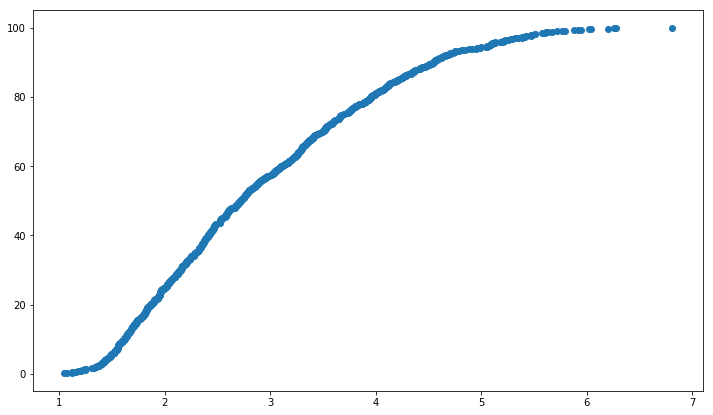

In [9]:
plt.scatter(incons, pers)
plt.show()

**Note:** That looks logistic-like, but not quite as pretty as one might hope

### Another set of 5x5s to see if random noise changes the shape

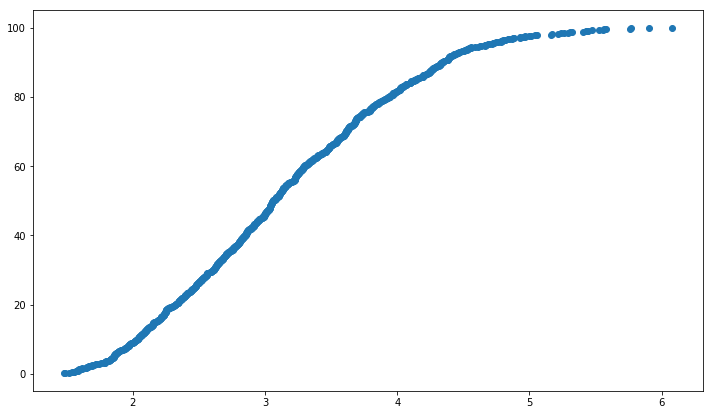

In [10]:
rnd_matrices = [rnd_cmp_mat(5) for i in range(1000)]
incons = [ar_consistency(mat) for mat in rnd_matrices]
pers = [percentileofscore(incons, x) for x in incons]
plt.scatter(incons, pers)
plt.show()

### 6x6 next

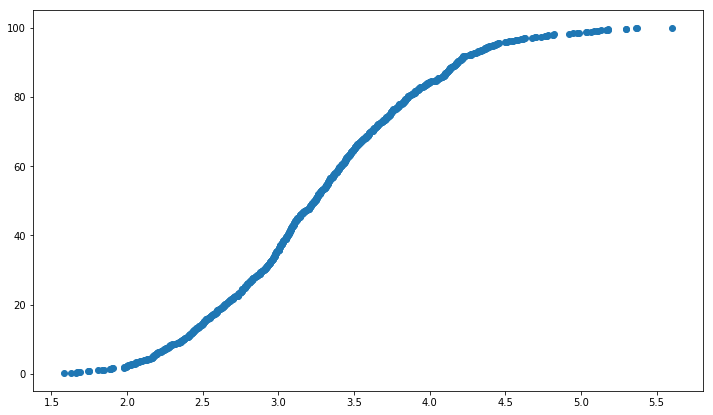

In [11]:
rnd_matrices = [rnd_cmp_mat(6) for i in range(1000)]
incons = [ar_consistency(mat) for mat in rnd_matrices]
pers = [percentileofscore(incons, x) for x in incons]
plt.scatter(incons, pers)
plt.show()

### 7x7

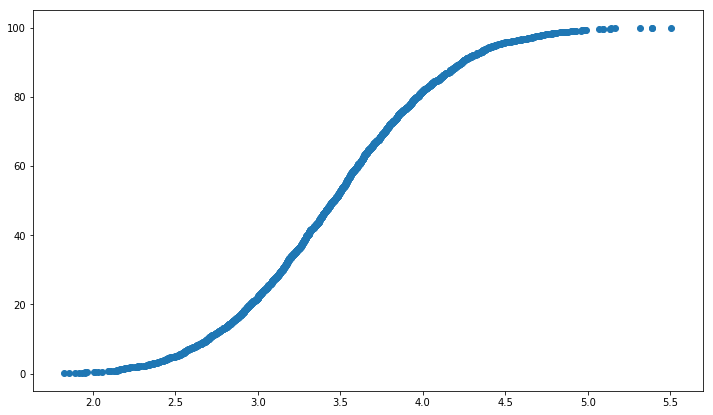

In [12]:
rnd_matrices = [rnd_cmp_mat(7) for i in range(2000)]
incons = [ar_consistency(mat) for mat in rnd_matrices]
pers = [percentileofscore(incons, x) for x in incons]
plt.scatter(incons, pers)
plt.show()

### 8x8

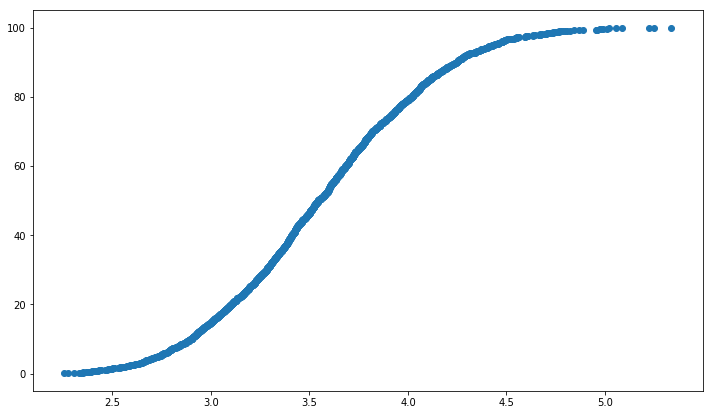

In [13]:
rnd_matrices = [rnd_cmp_mat(8) for i in range(2000)]
incons = [ar_consistency(mat) for mat in rnd_matrices]
pers = [percentileofscore(incons, x) for x in incons]
plt.scatter(incons, pers)
plt.show()

### 10x10

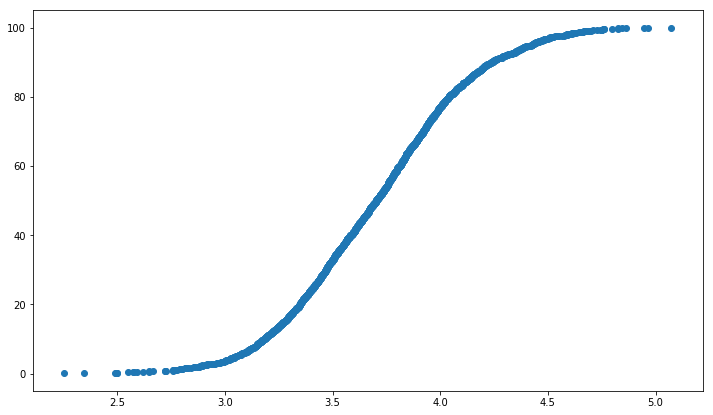

In [14]:
rnd_matrices = [rnd_cmp_mat(10) for i in range(2000)]
incons = [ar_consistency(mat) for mat in rnd_matrices]
pers = [percentileofscore(incons, x) for x in incons]
plt.scatter(incons, pers)
plt.show()

### 15x15

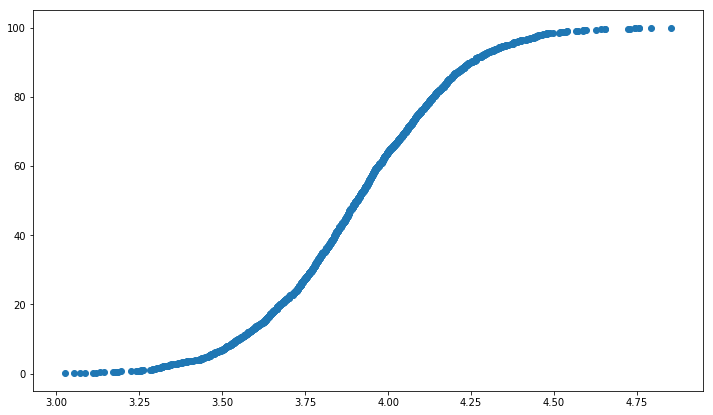

In [15]:
rnd_matrices = [rnd_cmp_mat(15) for i in range(2000)]
incons = [ar_consistency(mat) for mat in rnd_matrices]
pers = [percentileofscore(incons, x) for x in incons]
plt.scatter(incons, pers)
plt.show()

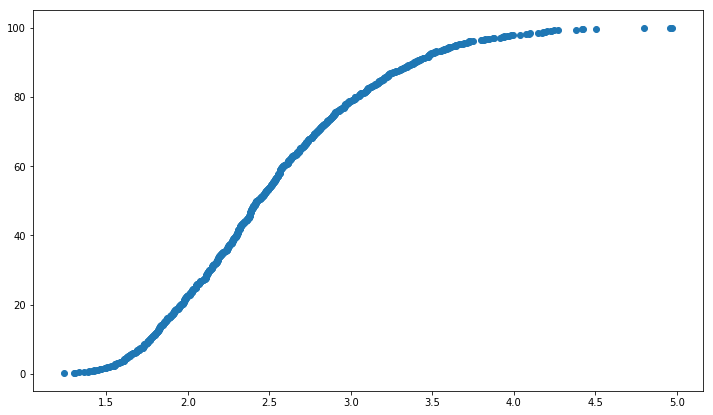

In [16]:
rnd_matrices = [rnd_cmp_mat_exp(5, 10) for i in range(1000)]
incons = [ar_consistency(mat) for mat in rnd_matrices]
pers = [percentileofscore(incons, x) for x in incons]
plt.scatter(incons, pers)
plt.show()

### 15x15 with entries up to 18

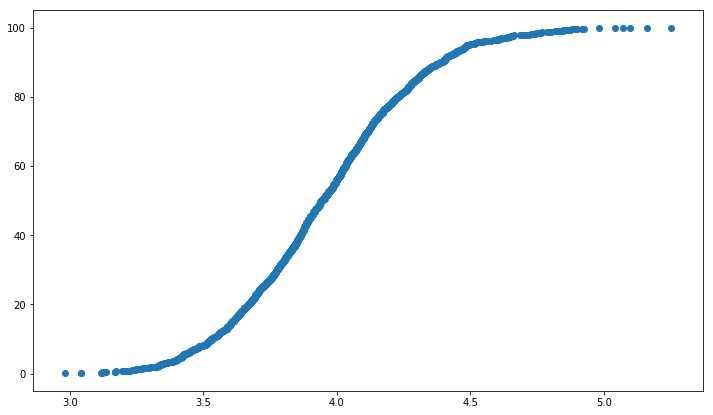

3.7213220670069678

3.9430832235874282

4.161883560412097

In [17]:
rnd_matrices = [rnd_cmp_mat_exp(15, 18) for i in range(2000)]
incons = [ar_consistency(mat) for mat in rnd_matrices]
pers = [percentileofscore(incons, x) for x in incons]
plt.scatter(incons, pers)
plt.show()
display(np.percentile(incons, 25))
display(np.percentile(incons, 50))
display(np.percentile(incons, 75))

# It looks logistic

The graphs we've seen look incredibily logistic.  Our next step is to find a logistic function that matches our data.  Since we are working with percentiles, a simple first approximation has:

* Lower Aysmptote of 0
* Upper Asymptote of 100
* x inflection at the 50th percentile value
* And then use the 75th percentile value to solve for the last logistic parameter

## Logistic formula with 75% level
Let's find the equation for a logistic defined standardly as
$$f(x)=\frac{a}{1+exp(b(x-x_{infl}))} + y_{\min}$$

Note that $a+y_{\min}=y_{\max}$, or in other words $a=y_{\min} - y_{\max}$.

We need to use the 75% level next:
$$f(x_{75})=0.75(y_{\max} - y_{\min}) + y_{\min} = y_{75}$$
$$\frac{a}{1+exp(b(x_{75}-x_{infl}))} + y_{\min} = y_{75}$$
$$\frac{a}{y_{75}-y_{\min}} = 1 + exp(b(x_{75}-x_{infl}))$$
$$\frac{a}{y_{75}-y_{\min}} - 1 = exp(b(x_{75}-x_{infl}))$$
$$\ln\left(\frac{a}{y_{75}-y_{\min}} - 1\right) = b(x_{75}-x_{infl})$$
$$\ln\left(\frac{a}{y_{75}-y_{\min}} - 1\right)\frac{1}{x_{75}-x_{infl}} = b$$

In [18]:

def logistic2(x, xinfl, x75, ymin, ymax):
    d = ymin
    a = ymax - ymin
    c = xinfl
    y75 = 0.75*(ymax-ymin) + ymin
    b = np.log(abs(a/(y75-ymin)-1))/(x75-xinfl)
    return a/(1+np.exp(b*(x-c))) + d
    

In [19]:
#A quick test, should spit back 0.75
logistic2(2, 1, 2, 0, 1)

0.75

## An experiment using that logistic

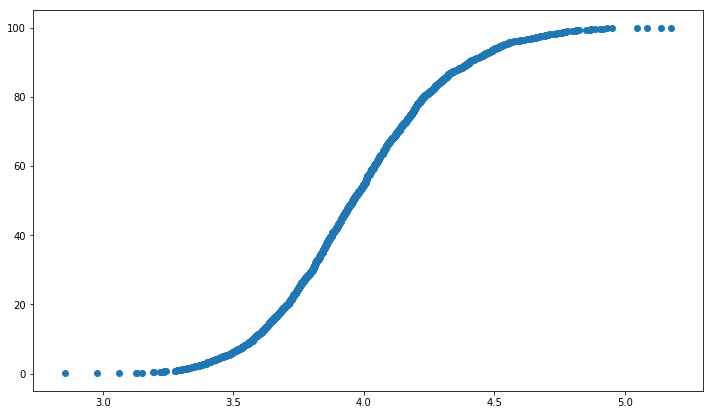

3.752776430005151

3.9578016960297173

4.182060302593182

In [20]:
rnd_matrices = [rnd_cmp_mat_exp(15, 18) for i in range(2000)]
incons = [ar_consistency(mat) for mat in rnd_matrices]
pers = [percentileofscore(incons, x) for x in incons]
plt.scatter(incons, pers)
plt.show()
display(np.percentile(incons, 25))
display(np.percentile(incons, 50))
display(np.percentile(incons, 75))

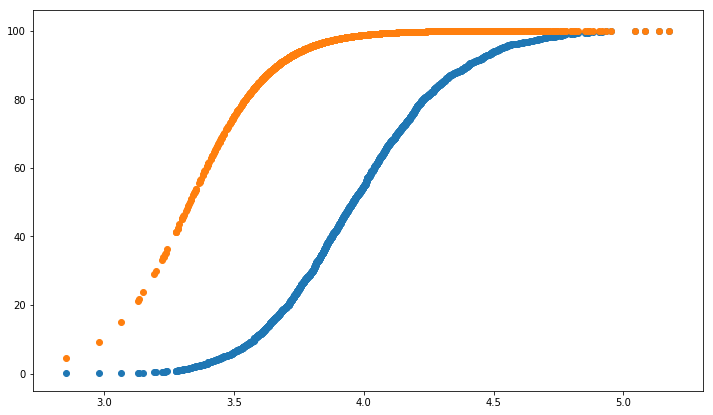

In [21]:
fx = lambda x: logistic2(x, 3.33, 3.5, 0, 100)
preds = [fx(x) - fx(1) for x in incons]
plt.scatter(incons, pers)
plt.scatter(incons, preds)

**NOTE:** That is a pretty incredible match

## More simulations (define the function)
This went so well, let's define a simulation function so we can try it repeatedly

In [22]:

def simulate(size, max_vote=18, nmats=1500, do_plot=True, return_percents=False):
    rnd_matrices = [rnd_cmp_mat_exp(size, max_vote) for i in range(nmats)]
    incons = [ar_consistency(mat) for mat in rnd_matrices]
    indices = np.argsort(incons)
    rnd_matrices = [rnd_matrices[i] for i in indices]
    incons = [incons[i] for i in indices]
    pers = percentile_sorted(incons)*100
    #pers = [percentileofscore(incons, x) for x in incons]
    x25 = np.percentile(incons, 25)
    xinfl = np.percentile(incons, 50)
    x75=np.percentile(incons, 75)
    avg = (x75 - x25)/2
    x75_better = xinfl+avg
    preds = np.array([logistic2(x, xinfl, x75, 0, 100) for x in incons])
    low = min(preds)
    up = 100
    preds = (preds - low)/(up - low) * 100
    if do_plot:
        plt.plot(incons, pers, "r-", label="Raw Data")
        plt.plot(incons, preds, "b--", label="Exponential Prediction")
        plt.legend()
        plt.show()
    if return_percents:
        return xinfl, x75_better

## Simulate 5x5 several times

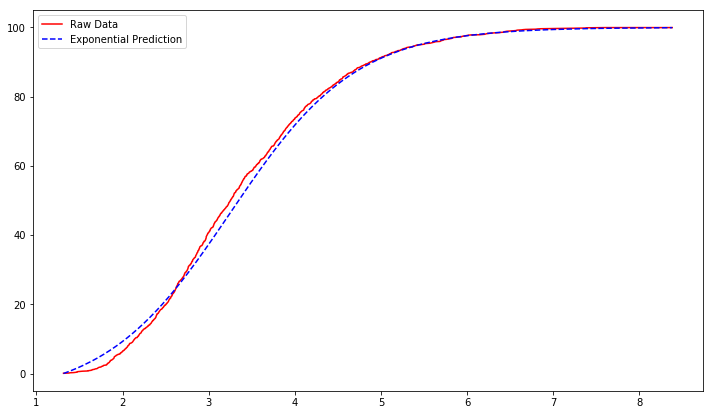

In [23]:
simulate(5)

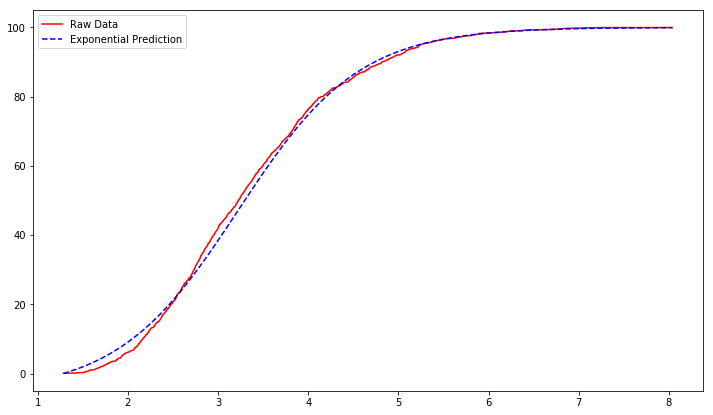

In [24]:
simulate(5)

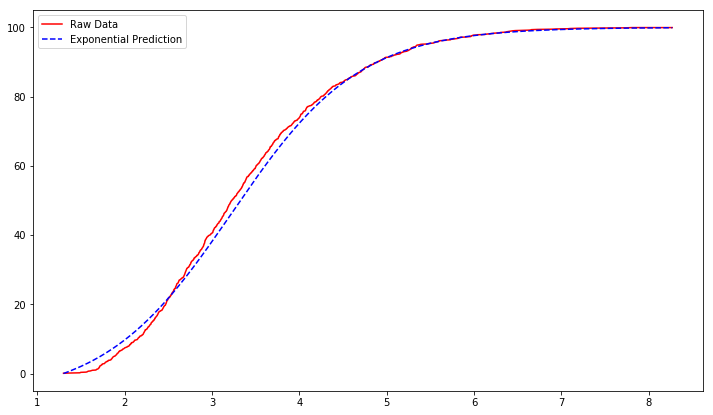

In [25]:
simulate(5)

## Simulate 3x3s

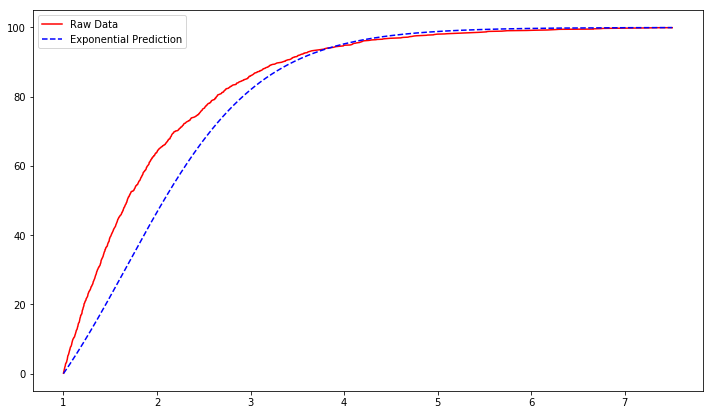

In [26]:
simulate(3,9)

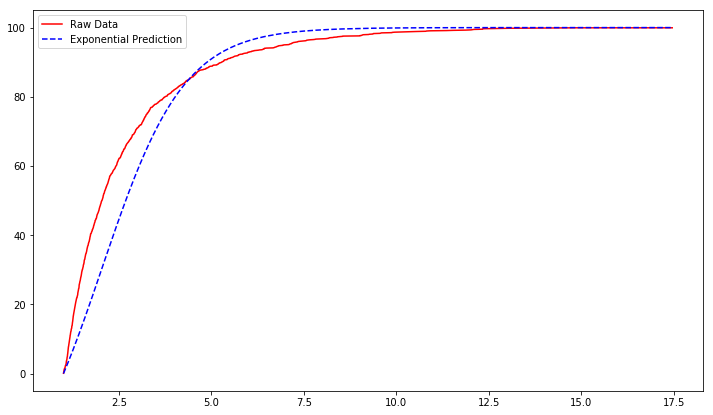

In [27]:
simulate(3, 20)

## Simulate 4x4s

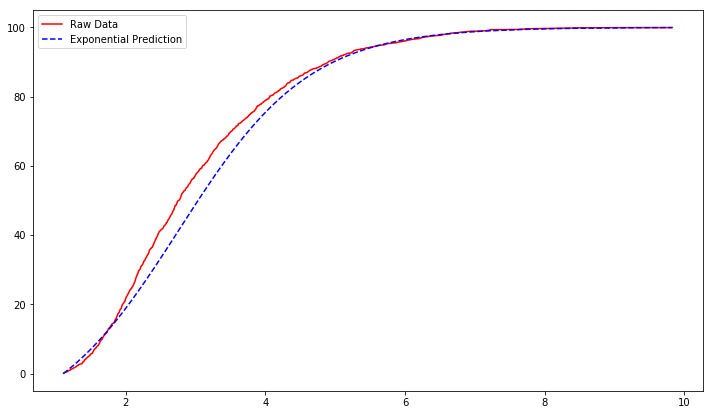

In [28]:
simulate(4)

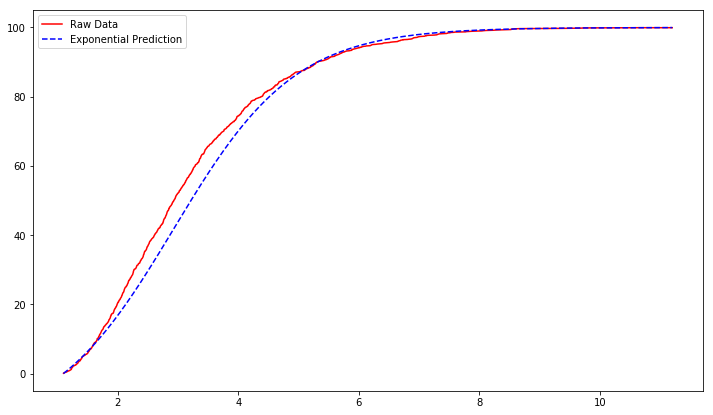

In [29]:
simulate(4, 20)

# Find a pattern in logistic maps

The goal in this section is to find the pattern in the parameters of the logistic functions we were plotting in the last example.  The parameters of the function are:

* 50th percentile location
* 75th percentile location

So, what we do in this section is merely run those experiments repeatedly and generate pairs (matrix_size, 50th_percentile) and (matrix_size, 75th)

In [30]:
pts50 = []
pts75 = []
xs = []
nsims_per_size = 8
for size in range(3,20):
    print("Working on matrices of size "+str(size))
    for i in range(nsims_per_size):
        x50, x75 = simulate(size=size,nmats=500, return_percents=True, do_plot=False)
        pts50.append(x50)
        pts75.append(x75)
        xs.append(size)

x50, x75 = simulate(size=30,nmats=500, return_percents=True, do_plot=False)
xs.append(30)
pts50.append(x50)
pts75.append(x75)

Working on matrices of size 3
Working on matrices of size 4
Working on matrices of size 5
Working on matrices of size 6
Working on matrices of size 7
Working on matrices of size 8
Working on matrices of size 9
Working on matrices of size 10
Working on matrices of size 11
Working on matrices of size 12
Working on matrices of size 13
Working on matrices of size 14
Working on matrices of size 15
Working on matrices of size 16
Working on matrices of size 17
Working on matrices of size 18
Working on matrices of size 19


In [31]:
x50, x75 = simulate(size=30,nmats=50, return_percents=True, do_plot=False)
xs.append(30)
pts50.append(x50)
pts75.append(x75)

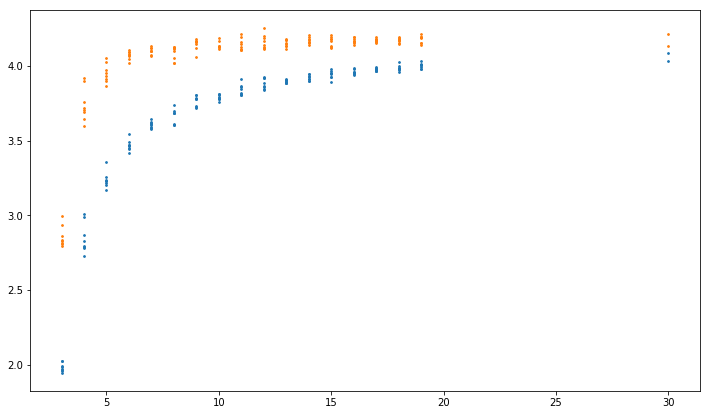

In [32]:
plt.scatter(xs, pts50, s=3)
plt.scatter(xs, pts75, s=3)
plt.show()

In [33]:
pts50[-1]

4.035782416918632

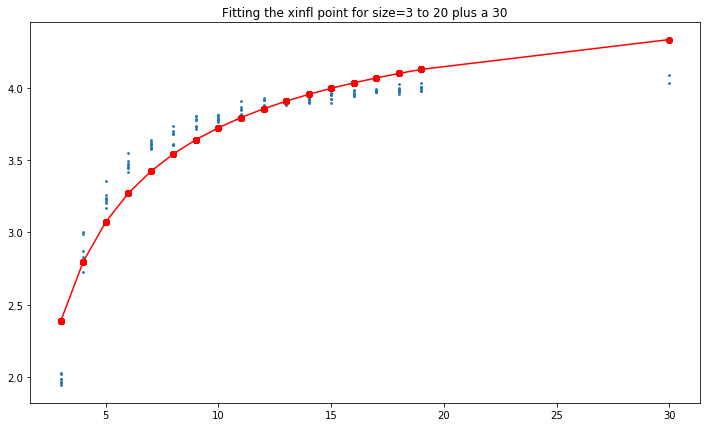

In [34]:
log_coeff, const = np.polyfit(1/np.array(xs)**0.6, pts50, deg=1)

fx = lambda x: log_coeff * 1/x**0.6 + const
preds50 = [fx(x) for x in xs]
plt.scatter(xs, pts50, s=3)
plt.plot(xs, preds50, 'r-o')
plt.title("Fitting the xinfl point for size=3 to 20 plus a 30")
plt.show()

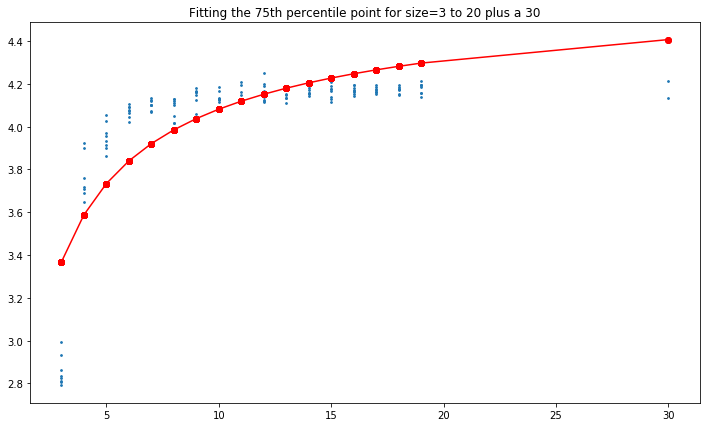

In [35]:
log_coeff, const = np.polyfit(1/np.array(xs)**0.6, pts75, deg=1)

fx = lambda x: log_coeff * 1/x**0.6 + const
preds75 = [fx(x) for x in xs]
plt.plot(xs, preds75, 'r-o')
plt.scatter(xs, pts75, s=3)
plt.title("Fitting the 75th percentile point for size=3 to 20 plus a 30")
plt.show()

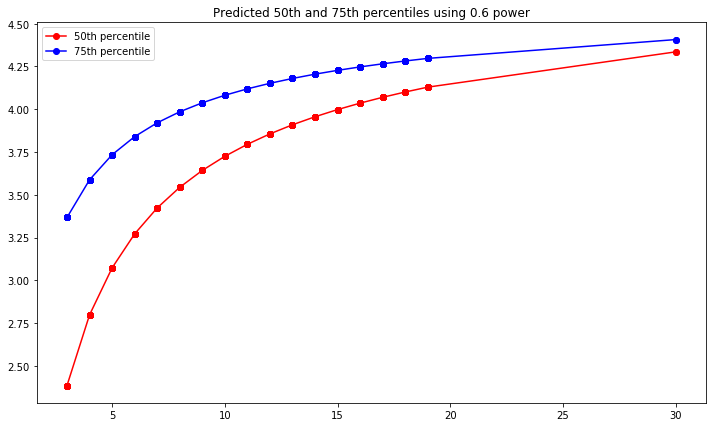

In [36]:
plt.plot(xs, preds50, 'r-o', label="50th percentile")
plt.plot(xs, preds75, 'b-o', label="75th percentile")
plt.legend()
plt.title("Predicted 50th and 75th percentiles using 0.6 power")
plt.show()

## Let's try to fit to a more sophisticated curve
$$f(x)=a x^b + c$$
Essentially before we fit with b=0.6, but let's try to do better

In [37]:
from scipy.optimize import curve_fit
from copy import deepcopy
axbcfx = lambda x, a, b, c: a*np.sign(x)*np.abs(x)**b + c
bounds = (
    (-10, -0.9, 3), (-1, -0.1, 6)
)
guess = (-5.64, -0.6, 4.51)
popt50, pconv = curve_fit(axbcfx, xs, pts50, p0=guess, bounds=bounds)
bounds75 = (
    (-10, -0.9, popt50[2]), (-1, -0.1, popt50[2]+0.5)
)
popt75, pconv = curve_fit(axbcfx, xs, pts75, p0=popt50, bounds = bounds75)

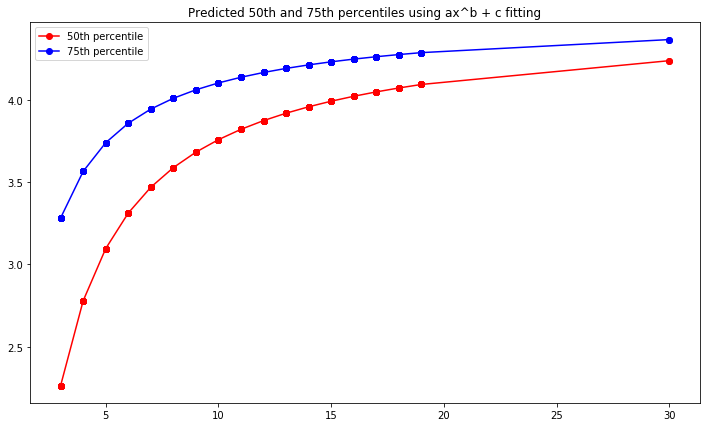

In [38]:
plt.plot(xs, axbcfx(xs, *popt50), 'r-o', label="50th percentile")
plt.plot(xs, axbcfx(xs, *popt75), 'b-o', label="75th percentile")
plt.legend()
plt.title("Predicted 50th and 75th percentiles using ax^b + c fitting")
plt.show()

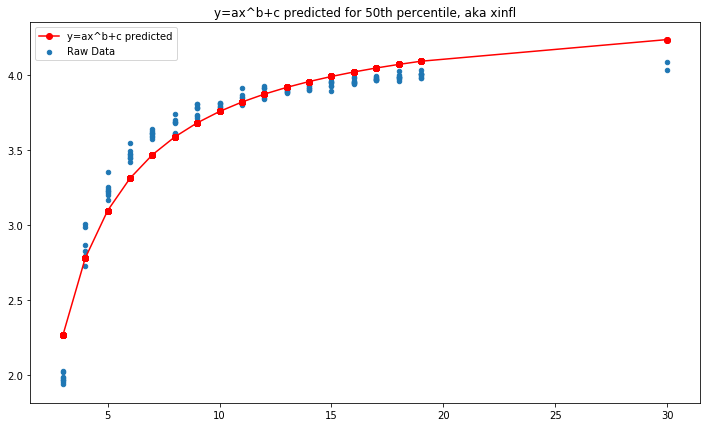

In [39]:
plt.plot(xs, axbcfx(xs, *popt50), 'r-o', label="y=ax^b+c predicted")
plt.scatter(xs, pts50, s=20, label='Raw Data')
plt.legend()
plt.title("y=ax^b+c predicted for 50th percentile, aka xinfl")
plt.show()

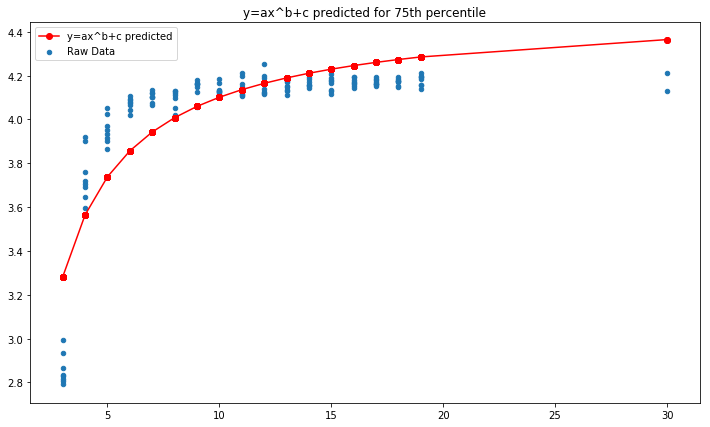

In [40]:
plt.plot(xs, axbcfx(xs, *popt75), 'r-o', label="y=ax^b+c predicted")
plt.scatter(xs, pts75, s=20, label='Raw Data')
plt.legend()
plt.title("y=ax^b+c predicted for 75th percentile")
plt.show()

### Conclusion for $y=ax^b+c$ fitting

In [41]:
eqn50 = "50th percentile equation $y = "+str(popt50[0])+"x^{"+str(popt50[1])+"} + "+str(popt50[2])+"$"
display(Markdown(eqn50))
eqn75 = "75th percentile equation $y = "+str(popt75[0])+"x^{"+str(popt75[1])+"} + "+str(popt75[2])+"$"
display(Markdown(eqn75))

50th percentile equation $y = -6.061897084689434x^{-0.8999999999999999} + 4.520249817971753$

75th percentile equation $y = -3.3277655089462077x^{-0.8999999999999999} + 4.520249817971754$

## Conclusion
These functions look perfect for predicting 50th and 75th percentiles, we should go with them.  Either the 0.6 power version initially or the more complex looking one stated in the $y=ax^b+c$ section

# Trying Gaussian
Let's try Gaussian instead of logistic.  We only need to calculate the standard deviation and error function to get our prediction function

In [42]:
from scipy.special import erf
def simulateg(size, max_vote=18, nmats=1500, do_plot=True, return_percents=False, power=2, perc_mean=50):
    rnd_matrices = [rnd_cmp_mat_exp(size, max_vote) for i in range(nmats)]
    incons = [ar_consistency(mat) for mat in rnd_matrices]
    indices = np.argsort(incons)
    rnd_matrices = [rnd_matrices[i] for i in indices]
    incons = [incons[i] for i in indices]
    pers = percentile_sorted(incons)*100
    #pers = [percentileofscore(incons, x) for x in incons]
    x25 = np.percentile(incons, 50)
    if perc_mean < 0:
        a = np.percentile(incons, -perc_mean)
        xinfl = min(incons) - a
    else:
        xinfl = np.percentile(incons, perc_mean)
    x75=np.percentile(incons, 75)
    avg = (x75 - x25)/2
    x75_better = xinfl+avg
    std = (x75-x25)**(1.0/power)
    mean = np.mean(incons)
    fx = lambda x: erf((x-xinfl)/std)
    gx = lambda x: (fx(x) - fx(1))/(1-fx(1))
    preds= np.array([gx(x) for x in incons])*100
    #preds = np.array([logistic2(x, xinfl, x75, 0, 100) for x in incons])
    low = min(preds)
    up = 100
    preds = (preds - low)/(up - low) * 100
    if do_plot:
        plt.plot(incons, pers, "r-", label="Raw Data")
        plt.plot(incons, preds, "b--", label="Exponential Prediction")
        plt.legend()
        plt.show()
    if return_percents:
        return xinfl, x75_better

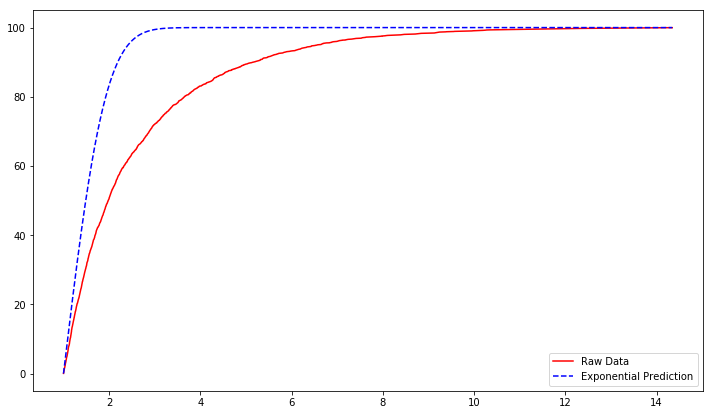

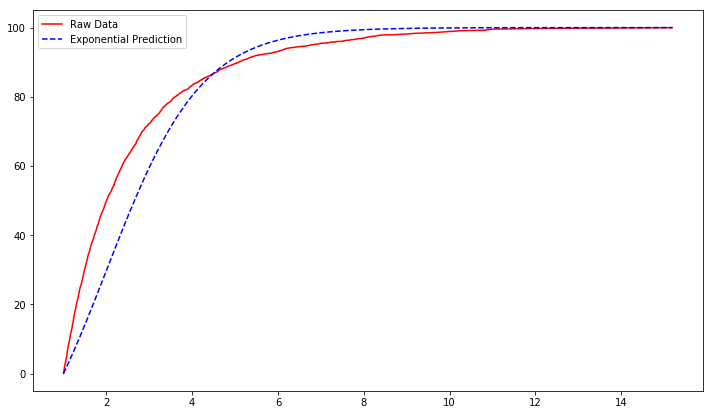

In [43]:
simulateg(3, nmats=3000, power=10, perc_mean=0)
simulate(3, nmats=3000)

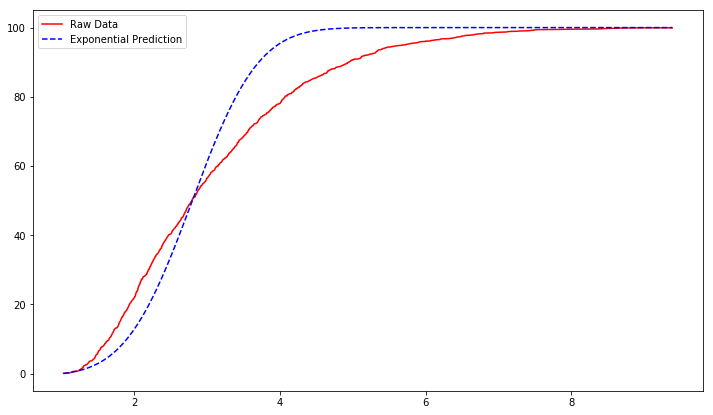

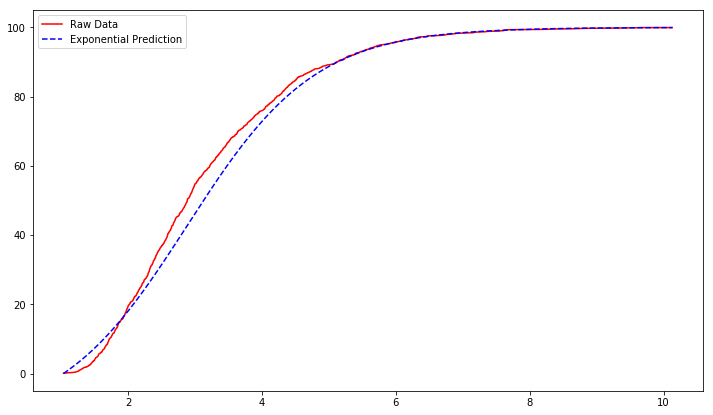

In [44]:
simulateg(4)
simulate(4)

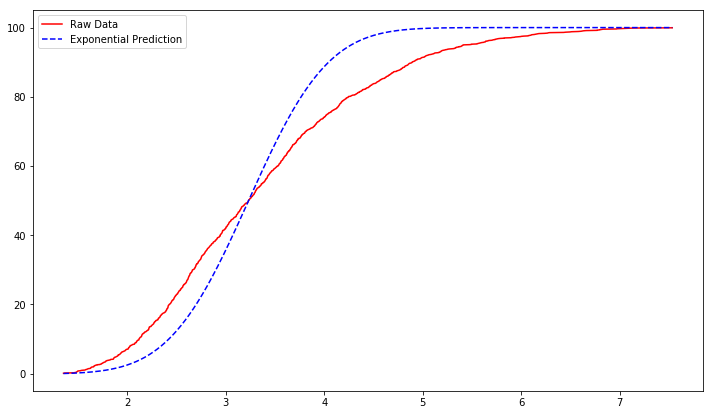

In [45]:
simulateg(5)

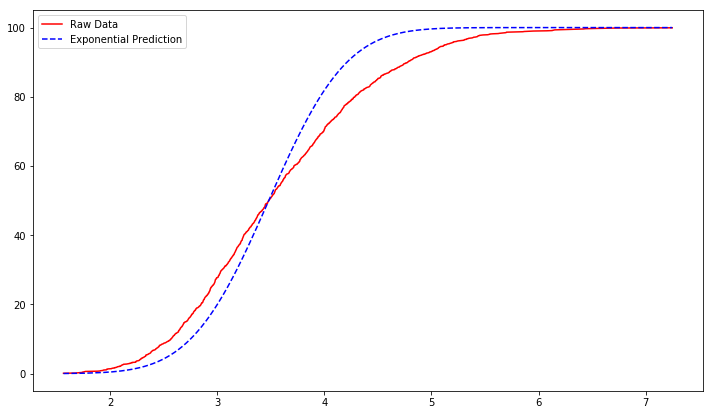

In [46]:
simulateg(6)

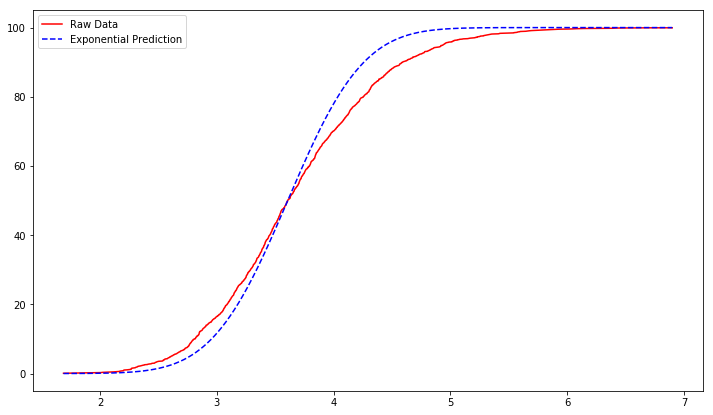

In [47]:
simulateg(7)

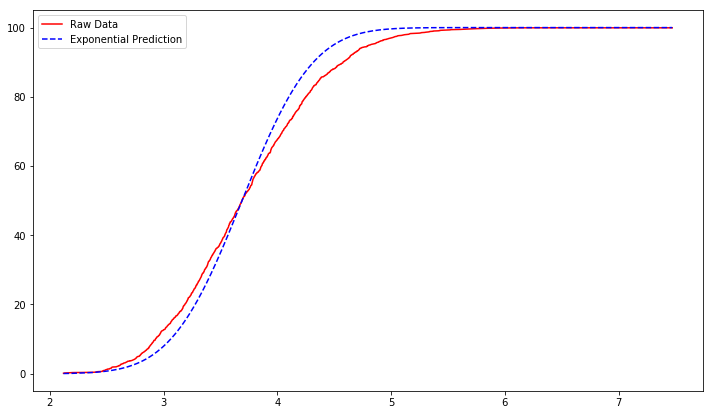

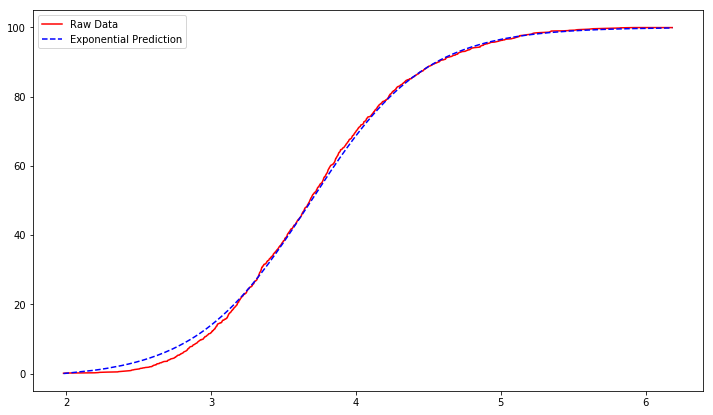

In [48]:
simulateg(8,power=2.1)
simulate(8)

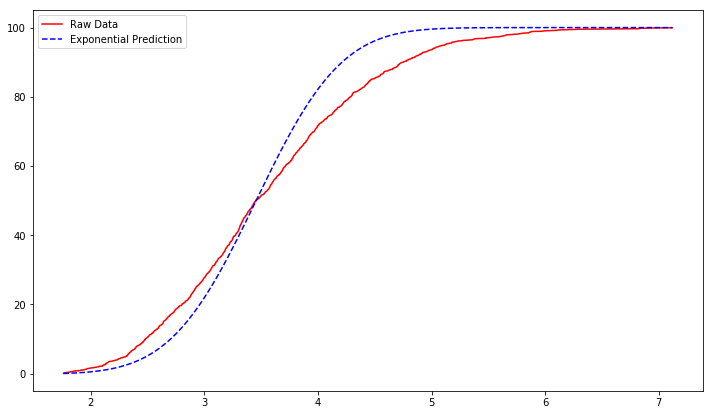

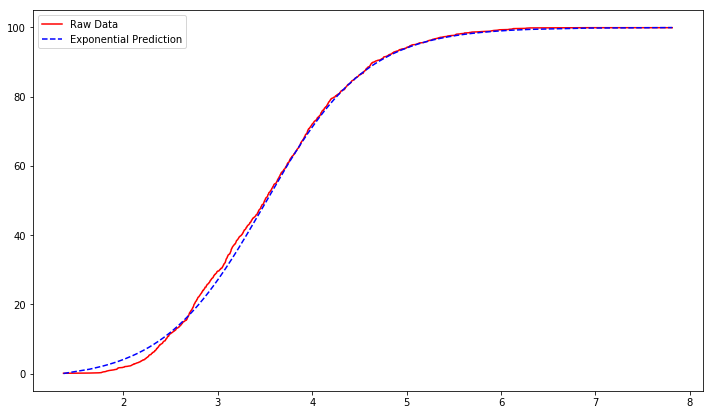

In [49]:
simulateg(6,power=2.2)
simulate(6)

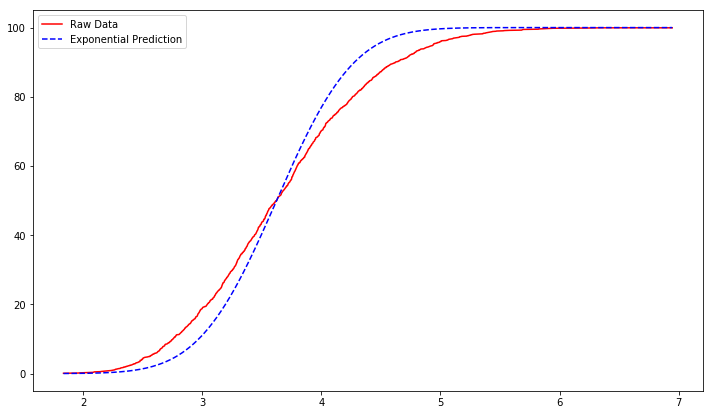

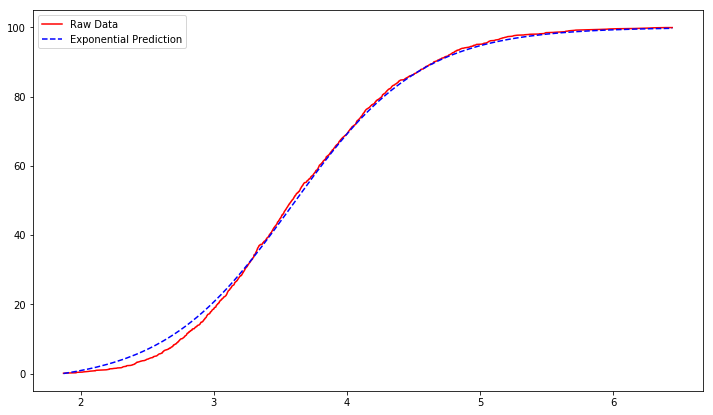

In [50]:
simulateg(7, power=2.15)
simulate(7)

## Conclusions of Gaussian
It worked better, but was more complicated as well, so I'm calling it now.  This could be a useful future research area.

# Piecewise exponential idea

In [51]:
def pw_exp(x, mu, p, x25, p25):
    b1 = np.log(p25/p) / (x25 - mu)
    A1 = p
    A2 = A1 - 1
    b2 = A1/A2 * b1
    if x <= mu:
        f = A1 * np.exp(b1 * (x - mu))
    else:
        f = A2 * np.exp(b2 * (x - mu)) + 1
    return f

In [52]:
def simulateb(size, max_vote=18, nmats=1500, do_plot=True, return_percents=False, perc_mean=50):
    rnd_matrices = [rnd_cmp_mat_exp(size, max_vote) for i in range(nmats)]
    incons = [ar_consistency(mat) for mat in rnd_matrices]
    indices = np.argsort(incons)
    rnd_matrices = [rnd_matrices[i] for i in indices]
    incons = [incons[i] for i in indices]
    pers = percentile_sorted(incons)*100
    #pers = [percentileofscore(incons, x) for x in incons]
    if perc_mean < 0:
        a = np.percentile(incons, -perc_mean)
        xinfl = min(incons) - a
    else:
        xinfl = np.percentile(incons, perc_mean)
    y25 = perc_mean/2
    x25=np.percentile(incons, y25)
    #avg = (x75 - x25)/2
    #x75_better = xinfl+avg
    #std = (x75-x25)**(1.0/power)
    #mean = np.mean(incons)
    gx = lambda x: pw_exp(x, xinfl, perc_mean/100, x25, y25/100)
    preds= np.array([gx(x) for x in incons])*100
    #preds = np.array([logistic2(x, xinfl, x75, 0, 100) for x in incons])
    low = min(preds)
    up = 100
    preds = (preds - low)/(up - low) * 100
    if do_plot:
        plt.plot(incons, pers, "r-", label="Raw Data")
        plt.plot(incons, preds, "b--", label="Exponential Prediction")
        plt.legend()
        plt.show()
    if return_percents:
        return xinfl, x75_better

## Some attempts

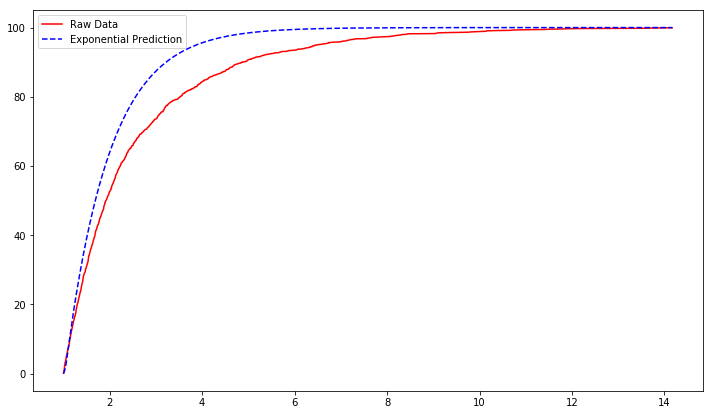

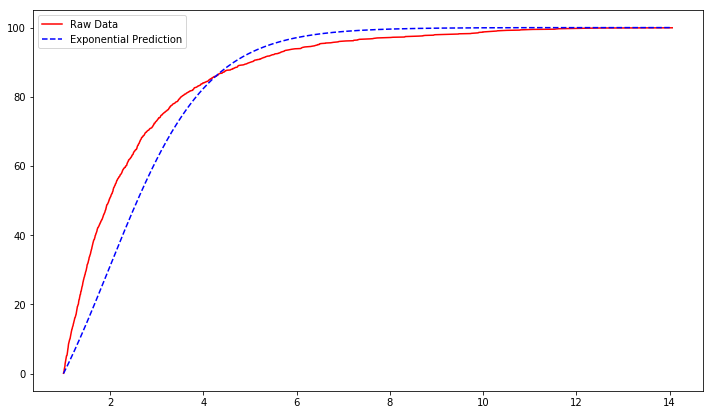

In [53]:
simulateb(3, perc_mean=5)
simulate(3)

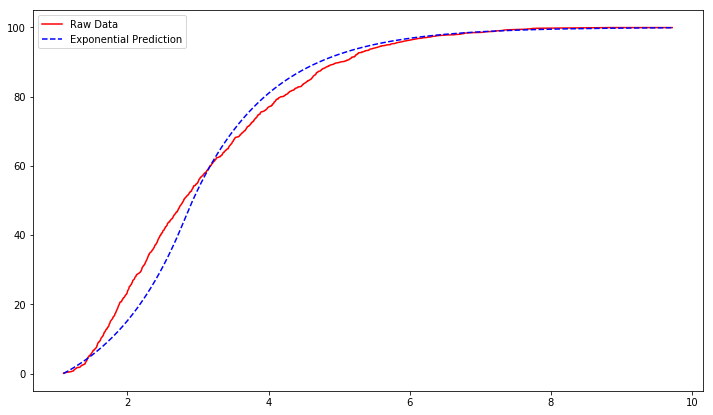

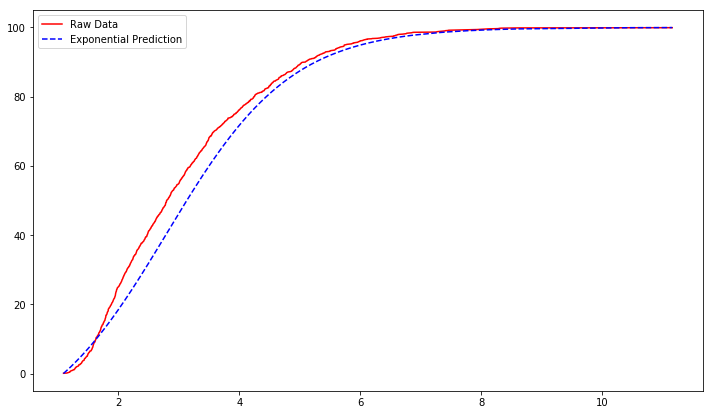

In [54]:
simulateb(4, perc_mean=50)
simulate(4)

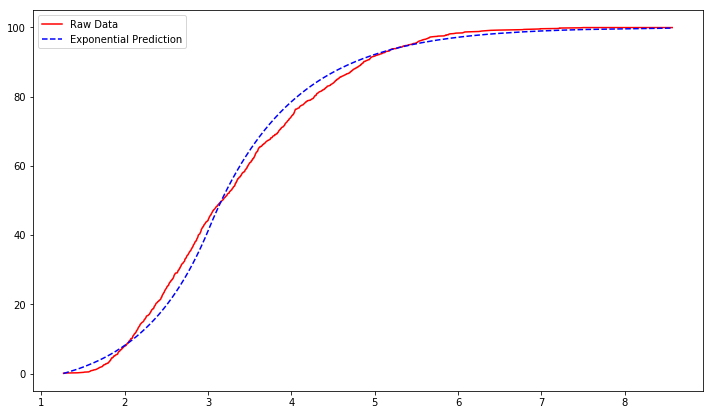

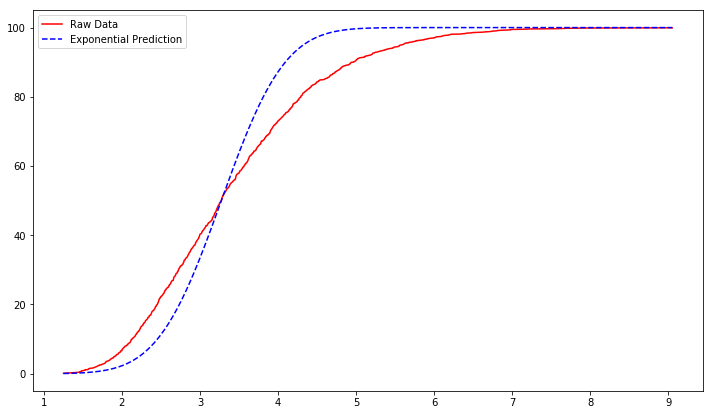

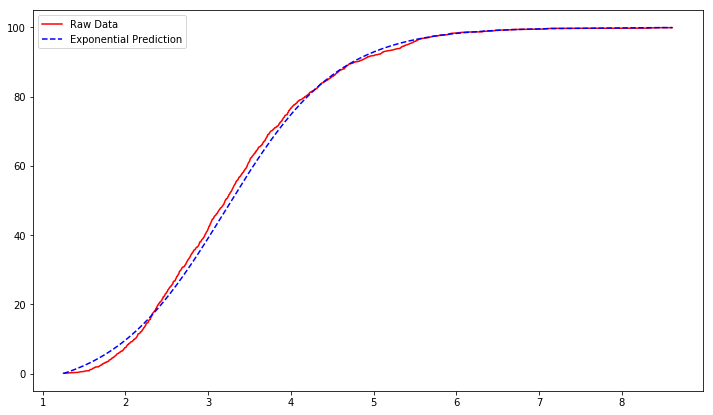

In [55]:
simulateb(5, perc_mean=45)
simulateg(5)
simulate(5)

## Conclusions
The new piecewise exponential appears to do no better, and often worse than logistic.

# Curve fit with logistic

In [56]:

def simulatelf(size, max_vote=18, nmats=1500, do_plot=True, return_percents=False, p50=50, xinfl_guess=None):
    rnd_matrices = [rnd_cmp_mat_exp(size, max_vote) for i in range(nmats)]
    incons = [ar_consistency(mat) for mat in rnd_matrices]
    indices = np.argsort(incons)
    rnd_matrices = [rnd_matrices[i] for i in indices]
    incons = [incons[i] for i in indices]
    pers = percentile_sorted(incons)*100
    #pers = [percentileofscore(incons, x) for x in incons]
    x25 = np.percentile(incons, 25)
    if xinfl_guess is None:
        xinfl = np.percentile(incons, p50)
    else:
        xinfl = xinfl_guess
    x75=np.percentile(incons, 75)
    avg = (x75 - x25)/2
    x75_better = xinfl+avg
    p0 = (xinfl, x75, 0, 100)
    bounds = (
        (-max(incons), -max(incons), 0, 99.9),
        (max(incons), max(incons), 0.01, 100)
    )
    popt, pconv = curve_fit(logistic2, incons, pers, p0=p0, bounds=bounds)
    preds = np.array([logistic2(x, *popt) for x in incons])
    low = min(preds)
    up = 100
    preds = (preds - low)/(up - low) * 100
    if do_plot:
        plt.plot(incons, pers, "r-", label="Raw Data")
        plt.plot(incons, preds, "b--", label="Exponential Prediction")
        plt.legend()
        plt.show()
    if return_percents:
        return popt

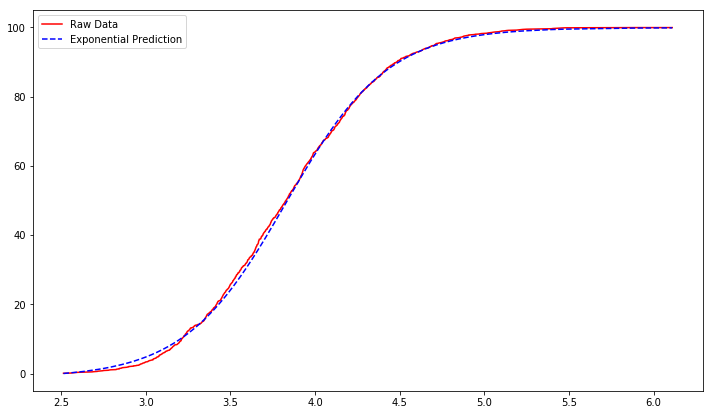

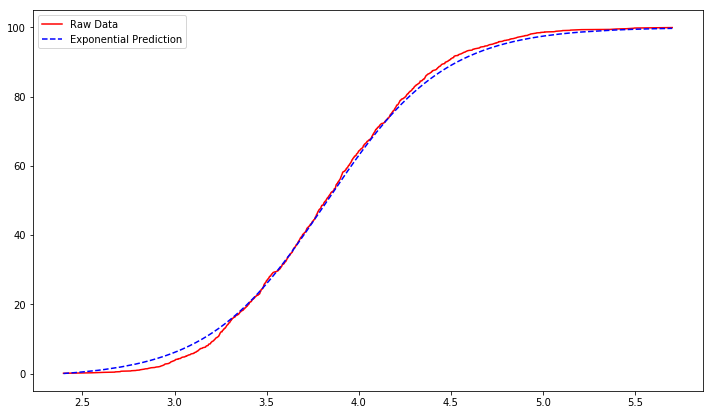

In [57]:
simulatelf(10)
simulate(10)

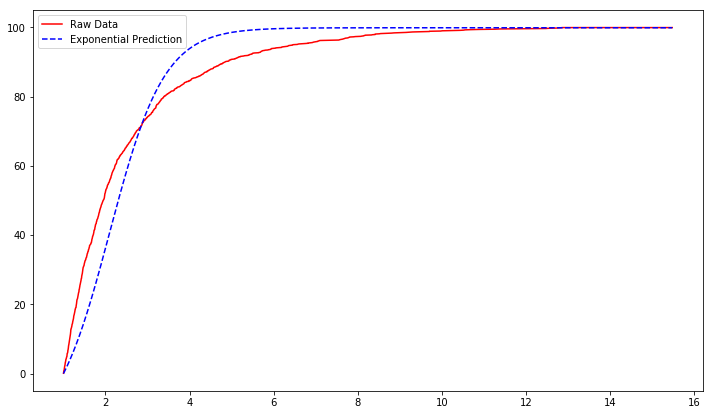

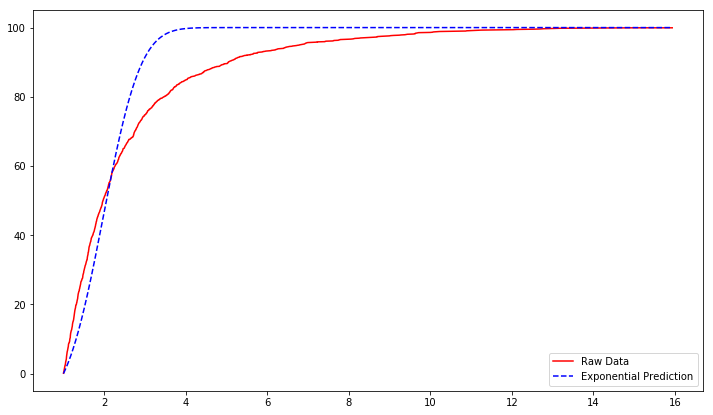

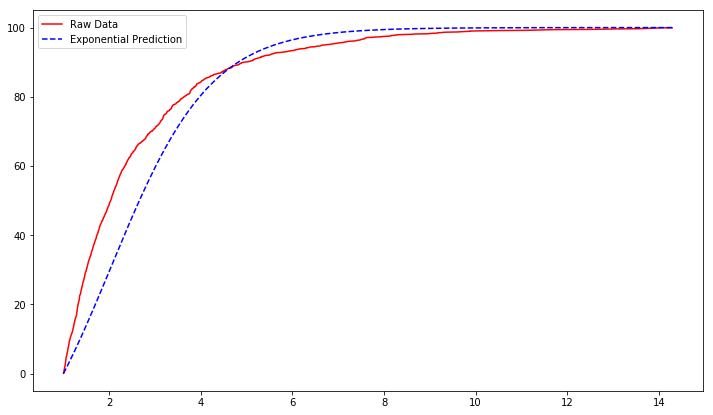

In [58]:
simulatelf(3, xinfl_guess=-1)
simulateg(3)
simulate(3)

## Conclusion

Much as the previous additions, this does not give significant improvement, amazingly.

# The AR-Inconsistency Formula and comparing to Saaty

In [59]:
popt50,popt75

(array([-6.06189708, -0.9       ,  4.52024982]),
 array([-3.32776551, -0.9       ,  4.52024982]))

In [60]:
def ar_incon_normalizer(size):
    params50 = (-5.97004965, -0.53482601,  4.7198059)
    params75 = (-5.36819674, -0.54483589,  4.7198059)
    fx = lambda x, a, b, c: a*x**b + c
    x50 = fx(size, *params50)
    x75 = fx(size, *params75)
    return lambda x: (logistic2(x, x50, x75, 0, 1) - logistic2(1, x50, x75, 0, 1)) / (1 - logistic2(1, x50, x75, 0, 1))

def ar_incon_normalized(mat):
    raw = ar_consistency(mat)
    normalizer = ar_incon_normalizer(len(mat))
    return normalizer(raw)

In [61]:
mat = rnd_cmp_mat(5)
ar_incon_normalized(mat)

0.4685129729843784

In [62]:
def ar_saaty_cmp(size = 3, max_vote=9, mats_per_size=500):
    ars = []
    saatys = []
    for i in range(mats_per_size):
        mat = rnd_cmp_mat(size=size, max_vote=max_vote)
        ars.append(ar_incon_normalized(mat))
        saatys.append(incon_std(mat))
    plt.scatter(ars, saatys, s=10)
    plt.title("Matrices of size "+str(size)+" AR Inconsistency vs Saaty")
    plt.xlabel("AR Inconsistency")
    plt.ylabel("Saaty Inconsistency")
    plt.show()

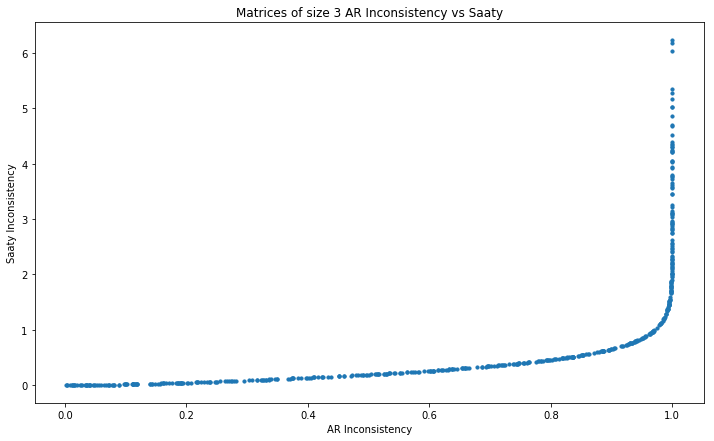

In [63]:
ar_saaty_cmp(3)

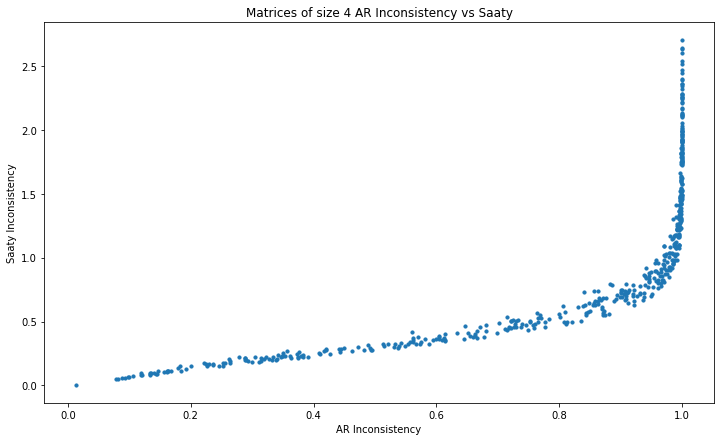

In [64]:
ar_saaty_cmp(size=4)

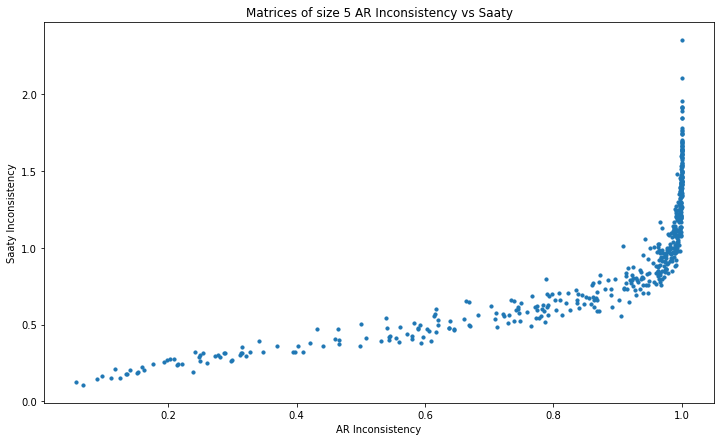

In [65]:
ar_saaty_cmp(5)

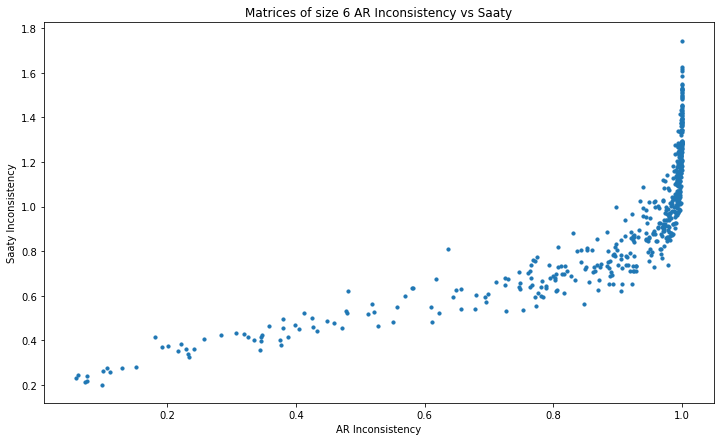

In [66]:
ar_saaty_cmp(6)

## Some simple matrices

The following are example matrices with the AR inconsistency shown first, then the Saaty

In [67]:
mat = np.array([
    [1, 2, 6],
    [1/2, 1, 3],
    [1/6, 1/3, 1]
])
display(ar_incon_normalized(mat))
display(incon_std(mat))

0.0

-4.2700885562506017e-16

In [68]:
mat = np.array([
    [1, 2, 8],
    [1/2, 1, 3],
    [1/8, 1/3, 1]
])
display(ar_incon_normalized(mat))
display(incon_std(mat))

0.07501250851848021

0.008848762220610321

In [69]:
mat = np.array([
    [1, 2, 1/6],
    [1/2, 1, 3],
    [6, 1/3, 1]
])
display(ar_incon_normalized(mat))
display(incon_std(mat))

0.9956013141495378

1.5430583470604067

In [70]:
mat = np.array([
    [1, 2, 4, 6],
    [1/2, 1, 2, 3],
    [1/4, 1/2, 1, 4],
    [1/6, 1/3, 1/4, 1]
])
display(ar_incon_normalized(mat))
display(incon_std(mat))

0.07160561367663025

0.045910208290874756

In [71]:
mat = np.array([
    [1, 2, 2, 1],
    [1/2, 1, 2, 2],
    [1/2, 1/2, 1, 4],
    [1, 1/2, 1/4, 1]
])
display(ar_incon_normalized(mat))
display(incon_std(mat))

0.34419954225848187

0.21465320002969746

In [72]:
mat = np.array([
    [1, 6, 3, 6],
    [1/6, 1, 1/2, 2],
    [1/3, 2, 1, 4],
    [1/6, 1/2, 1/4, 1]
])
display(ar_incon_normalized(mat))
display(incon_std(mat))

0.04201732425052835

0.02271424253778665

# The AR-Inconsistency Formula and comparing to GCI

In [81]:
def ar_gci_cmp(size = 3, max_vote=9, mats_per_size=500):
    ars = []
    gcis = []
    for i in range(mats_per_size):
        mat = rnd_cmp_mat(size=size, max_vote=max_vote)
        ars.append(ar_incon_normalized(mat))
        gcis.append(incon_std(mat))
    plt.scatter(ars, gcis, s=10)
    plt.title("Matrices of size "+str(size)+" AR Inconsistency vs GCI")
    plt.xlabel("AR Inconsistency")
    plt.ylabel("GCI Inconsistency")
    plt.show()

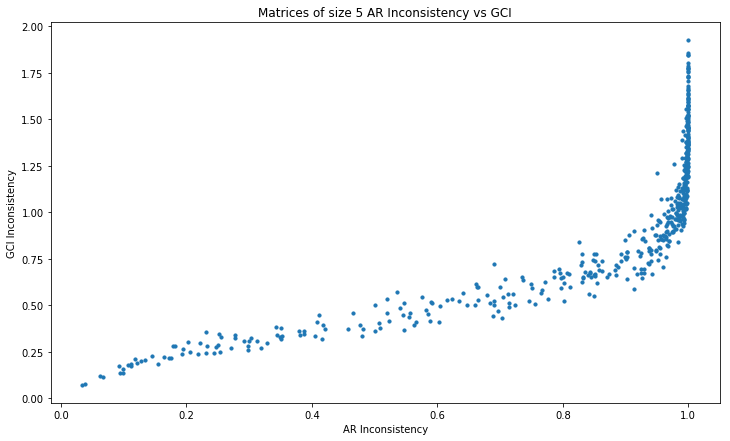

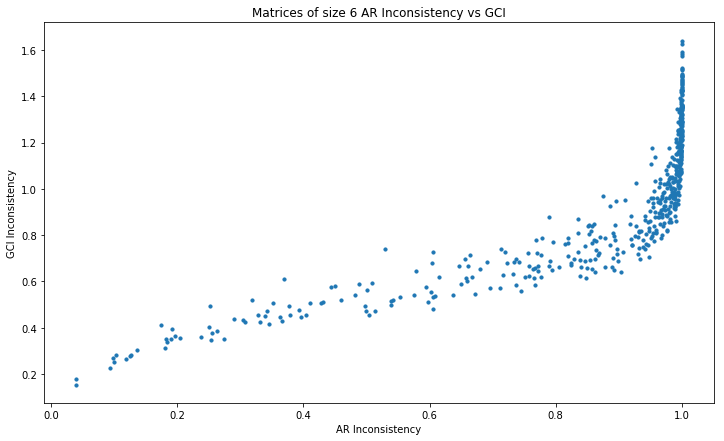

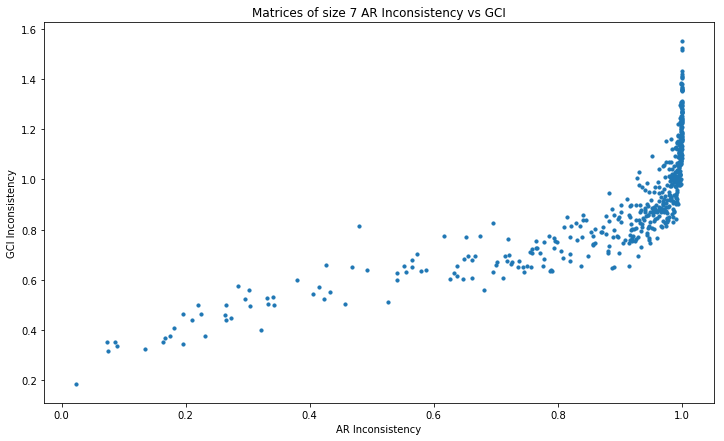

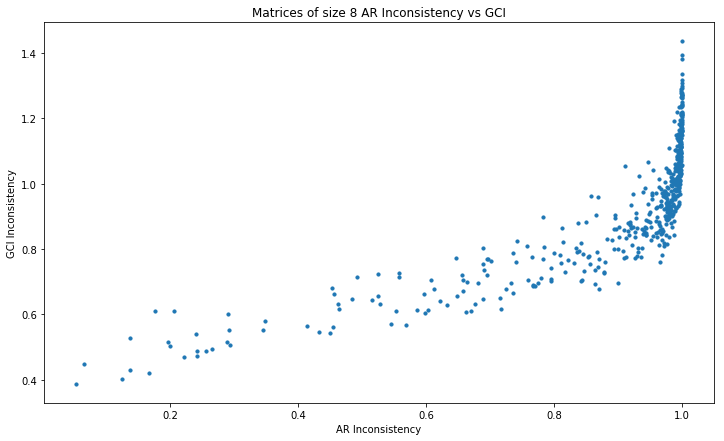

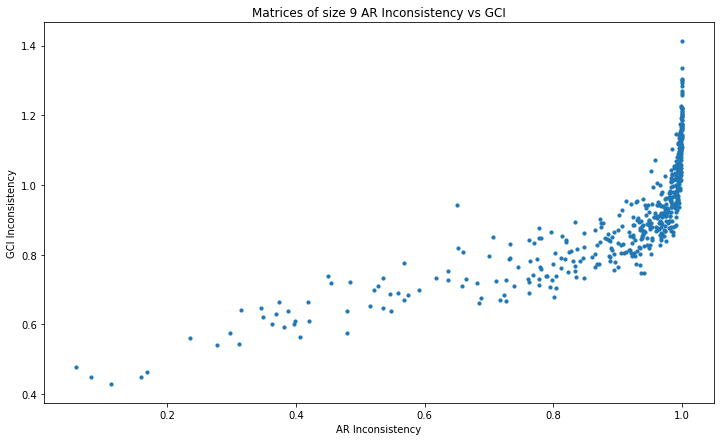

In [83]:
for size in range(5, 10):
    ar_gci_cmp(size)